# LangGraph Agent: Tool Calling & RAG with Tavily


**This notebook showcases a self-correcting AI agent built with LangGraph to enable intelligent tool use and real-time knowledge retrieval.**

### Core Functionality
**Intelligent Routing**: The agent uses a conditional ReAct loop to decide dynamically if a question requires a web search.

**Tool**: The agent is connected to the Tavily API for Retrieval-Augmented Generation (RAG), allowing it to answer current and factual questions.

**Workflow**: The LangGraph structure ensures the agent only proceeds to the tool execution (ToolNode) when the LLM explicitly requests it, optimizing resource use.

Key Components
* `llm.bind_tools`: Teaches the LLM what tools exist (the Decision).
* `ToolNode`: Executes the Python code of the tool (the Action).
* `should_continue`: The gate that directs the flow based on the LLM's decision (the Routing).

In [83]:
#!pip install langgraph langchain[openai] tavily-python

In [84]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)

api_key_file = '/content/drive/MyDrive/api_key.txt'
with open(api_key_file, 'r', encoding = 'utf-8-sig') as file:
    api_key = file.read().strip()

print(api_key is not None)
os.environ['OPENAI_API_KEY'] = api_key
print("OpenAI API key loaded:", os.environ.get('OPENAI_API_KEY') is not None)

Mounted at /content/drive
True
OpenAI API key loaded: True


In [85]:
tavily_key_file = '/content/drive/MyDrive/tavily.txt'
with open(tavily_key_file, 'r', encoding = 'utf-8-sig') as file:
    tavily_key = file.read().strip()

print(tavily_key is not None)
os.environ['TAVILY_API_KEY'] = tavily_key
print("Tavily key loaded:", os.environ.get('TAVILY_API_KEY') is not None)

True
Tavily key loaded: True


In [86]:
from typing_extensions import TypedDict, List, Annotated, Literal

# LangGraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

# Langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool

# Tavily -- An search API used for RAG tool
from tavily import TavilyClient
from uuid import uuid4


llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0)

In [87]:
class ChatState(TypedDict):
  messages: Annotated[List[BaseMessage], add_messages]


@tool
def tavily_search(query:str) -> str:
  '''
  Search the web for current information using Tavily.

  Args:
    query: The search query string.

  Returns:
    Search result as a formatted string.
  '''

  client = TavilyClient(api_key = os.environ.get('TAVILY_API_KEY'))
  response:dict = client.search(query, max_result = 3)

  results:list = []
  for result in response.get('results', []):
    results.append(f"Title: {result['title']}\nURL: {result['url']}\nContent: {result['content']}\n")

  return "\n---\n".join(results) if results else "No results found."


# Tool List
tools = [tavily_search]
llm_with_tools = llm.bind_tools(tools)  # Telling to the llm that thoses tools exist

tool_node = ToolNode(tools = tools)     # Node already builded by LangGraph -> Not AI just node

In [88]:
def answer_node(state:ChatState) -> ChatState:
    human_msg: HumanMessage = state['messages']
    prompt_content = ("You are a helpful and polite assistant. "
                      "Your top priority is conciseness. "
                      "Answer strictly the specific question asked in a cordial manner, "
                      "without adding unnecessary context or filler.")
    system_prompt = SystemMessage(content = prompt_content)
    ai_msg: AIMessage = llm_with_tools.invoke([system_prompt] + human_msg)
    return {'messages': [ai_msg]}

In [89]:
def should_continue(state:ChatState) -> Literal['tools', 'end']:
  last_msg = state['messages'][-1]
  if hasattr(last_msg, 'tool_calls') and last_msg.tool_calls:   # Checks if the object (last_msg) has a specific attribute (tool_calls) & Exist.
      return 'tools'
  return 'end'

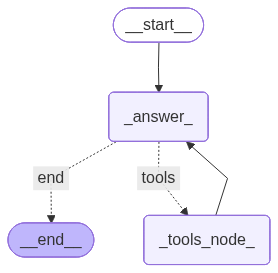

In [90]:
checkpointer = MemorySaver()

builder = StateGraph(ChatState)
builder.add_node('_answer_', answer_node)
builder.add_node('_tools_node_', tool_node)

builder.add_edge(START, '_answer_')
builder.add_conditional_edges('_answer_',
                              should_continue,
                               {'tools': '_tools_node_', 'end': END})
builder.add_edge('_tools_node_', '_answer_')
builder.add_edge('_answer_', END)

graph = builder.compile(checkpointer = checkpointer)
graph


In [100]:
cfg = {'configurable': {'thread_id': str(uuid4())}}

In [148]:
response = graph.invoke({'messages': [HumanMessage(content = 'What is the capital of France?')]}, config = cfg)

In [149]:
print(response['messages'][-1].content)

The capital of France is Paris.


In [162]:
last_question = None
current_tools = []

for msg in response['messages']:

    # If it's a QUESTION: We note it down and clear the list of previous tools
    if isinstance(msg, HumanMessage):
        last_question = msg.content
        current_tools = [] # Reset pour la nouvelle question

    # If it's a TOOL request: We add the name to the list
    elif isinstance(msg, AIMessage) and msg.tool_calls:
        for tool in msg.tool_calls:
            current_tools.append(tool['name'])

    # If this is the FINAL ANSWER (Text + No tool call): The entire block is displayed
    elif isinstance(msg, AIMessage) and msg.content and not msg.tool_calls:
        print(f"Question : {last_question}")
        print(f"Answer  : {msg.content}")

        # If the list is empty, 'None' is displayed; otherwise, the list
        tools_display = ", ".join(current_tools) if current_tools else "No Tools"
        print(f"Tools    : {tools_display}")
        print("-" * 40)

Question : What is the weather in New York today? 
Answer  : Today in New York, the weather is partly cloudy with a temperature of 34°F (1.1°C). The wind is coming from the ENE at 2.2 mph, and the humidity is at 56%.
Tools    : tavily_search
----------------------------------------
Question : Has the Italian national team qualified for the 2026 World Cup? If not, which team will play in the playoffs?
Answer  : The Italian national team has not qualified for the 2026 World Cup directly. They will participate in a 16-team UEFA playoff for a chance to qualify.
Tools    : tavily_search
----------------------------------------
Question : What is the capital of France?
Answer  : The capital of France is Paris.
Tools    : No Tools
----------------------------------------
